In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.4 MB/s eta 0:00:00


# Nowa sekcja

In [2]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

import torch
import torch.nn as nn
from torch_geometric.nn import TransformerConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Subset
import copy

In [3]:
qm9 = QM9(root="./data")

Extracting data/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [4]:
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [ ]:
len(qm9)

130831

In [5]:
qm9.data.y

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[  0.0000,  13.2100, -10.5499,  ..., 157.7118, 157.7100, 157.7070],
        [  1.6256,   9.4600,  -6.9933,  ..., 293.6097, 293.5411, 191.3940],
        [  1.8511,   6.3100,  -7.9675,  ..., 799.5881, 437.9039, 282.9455],
        ...,
        [  1.2480,  73.6000,  -6.0763,  ...,   3.6712,   2.1431,   1.8950],
        [  1.9576,  77.4000,  -5.7743,  ...,   3.5285,   2.1513,   1.8658],
        [  0.8626,  69.4800,  -6.3022,  ...,   3.6402,   2.2176,   1.9379]])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
y = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y[0]).to(device)


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
X = torch.Tensor(qm9.data.x).to(device)

In [9]:
qm9 = qm9.shuffle()
data_size = len(qm9)

train_index = int(data_size * 0.8)
val_index = train_index + int(data_size * 0.1)
test_index = val_index + int(data_size * 0.1)

data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()
qm9.data.y = (qm9.data.y - data_mean) / data_std

train_set = qm9.data.y[:train_index]
val_set = qm9.data.y[train_index:(train_index + val_index)]
test_set = qm9.data.y[(train_index + val_index):]

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [10]:
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:val_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[val_index:test_index], batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [49]:
class LinearModel(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [11]:
class PerceptronModelAdvanced(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.linear1 = nn.Linear(dim_h, dim_h)
        self.linear2 = nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = x.relu()
        x = self.linear2(x)
        return x

In [12]:
def training(loader, model, loss, optimizer):
    model.train()
    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d = d.to(device)
        d.x = d.x.to(device)
        d.y = d.y.to(device)
        d.x = d.x.float()
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [14]:
def validation(loader, model, loss):
    model.eval()
    val_loss = 0
    for d in loader:
        d = d.to(device)
        d.x = d.x.to(device)
        d.y = d.y.to(device)
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [31]:
def testing(loader, model):
    with torch.no_grad():
        model.eval()
        loss = torch.nn.MSELoss()
        test_loss = 0
        test_target = numpy.empty((0))
        test_y_target = numpy.empty((0))
        for d in loader:
            d = d.to(device)
            d.x = d.x.to(device)
            d.y = d.y.to(device)
            out = model(d)
            l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
            test_loss += l / len(loader)
            test_target = numpy.concatenate((test_target, out.cpu().detach().numpy()[:, 0]))
            test_y_target = numpy.concatenate((test_y_target, d.y.cpu().detach().numpy()))

    return test_loss, test_target, test_y_target

# Nowa sekcja

In [15]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            d = d.to(device)
            d.x = d.x.to(device)
            d.y = d.y.to(device)
            out = model(d)
            if epoch == epochs - 1:
                train_target = numpy.concatenate((train_target, out.cpu().detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.cpu().detach().numpy()))

        train_loss[epoch] = epoch_loss.cpu().detach().numpy()
        val_loss[epoch] = v_loss.cpu().detach().numpy()

        print(
            "Epoch: "
            + str(epoch)
            + ", Train loss: "
            + str(epoch_loss.item())
            + ", Val loss: "
            + str(v_loss.item())
        )
    return train_loss, val_loss, train_target, train_y_target

In [ ]:
epochs = 100

linear_adv_model = LinearModelAdvanced(dim_h=64).to(device)


linear_adv_train_loss, linear_adv_val_loss, linear_adv_train_target, linear_adv_train_y_target = train_epochs(
    epochs, linear_adv_model, train_loader, test_loader, "linear_model_best.pt"
)

In [ ]:
epochs = 100

perceptron_adv_model_2 = PerceptronModelAdvanced(dim_h=64).to(device)


perceptron_adv_train_loss_2, perceptron_adv_val_loss_2, perceptron_adv_train_target_2, perceptron_adv_train_y_target_2 = train_epochs(
    epochs, perceptron_adv_model_2, train_loader, test_loader, "perceptron_model3.pt"
)

In [58]:
def plot_loss(gcn_train_loss, gcn_val_loss):
    plt.plot(gcn_train_loss, label="Train loss")
    plt.plot(gcn_val_loss, label="Val loss")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [22]:
def plot_targets(pred, ground_truth):
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

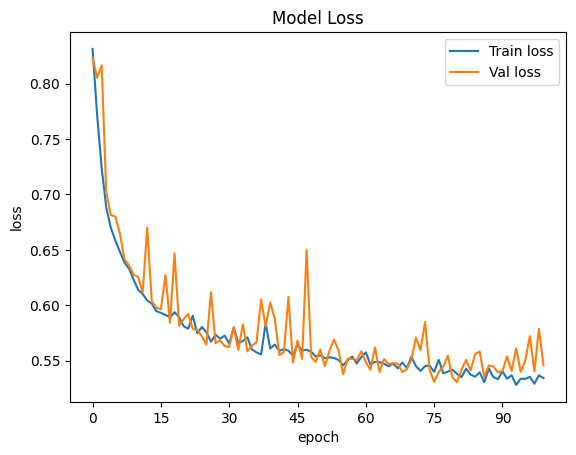

In [59]:
plot_loss(linear_adv_train_loss,linear_adv_val_loss)

Test Loss for Linear best: 0.545595645904541


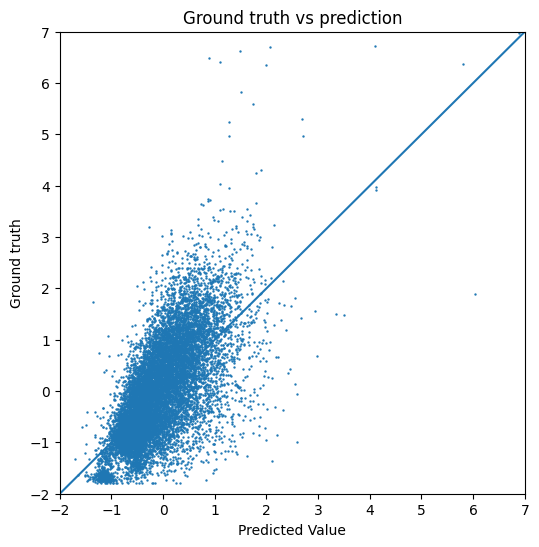

In [55]:

model = LinearModelAdvanced(dim_h=64).to(device)
model.load_state_dict(torch.load("linear_model_best.pt"))

gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)



print("Test Loss for Linear best: " + str(gcn_test_loss.item()))

plot_targets(gcn_test_target, gcn_test_y)

In [60]:
import numpy as np

def mean_absolute_error(predictions, targets):
    predictions = np.array(predictions)
    targets = np.array(targets)
    absolute_errors = np.abs(predictions - targets)
    mae = np.mean(absolute_errors)

    return mae

# Oblicz MAE
mae_result = mean_absolute_error(gcn_test_target, gcn_test_y)

print(f"Mean Absolute Error: {mae_result}")

Mean Absolute Error: 0.5449150267782996
